In [5]:
from pathlib import Path
import tvm
from tvm import te, relay, transform
from tvm.contrib import graph_executor as runtime
import imageio
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tflite

In [6]:
model_path = Path.cwd().parent / 'models' / 'deeplabv3' / 'lite-model_deeplabv3_1_metadata_2.tflite'
model_path.exists()

True

In [10]:
with open(model_path, 'rb') as f:
    tflite_model_buf = f.read()
    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
    input_tensor = "sub_7"
    input_shape  = (1, 257, 257, 3)
    input_dtype  = "float32"
    
    mod, params = relay.frontend.from_tflite(
        tflite_model, 
        shape_dict = {input_tensor: input_shape},
        dtype_dict = {input_tensor: input_dtype}
    )
    target = "llvm"
    
    desired_layouts = {'nn.conv2d': ['NCHW', 'default']}

    # Convert the layout to NCHW
    seq = tvm.transform.Sequential([relay.transform.RemoveUnusedFunctions(),
                                    relay.transform.ConvertLayout(desired_layouts)])
    
    with transform.PassContext(opt_level=3):
        mod = seq(mod)
        lib=relay.build(mod, target, params=params)
        lib.export_library(str(model_path.with_suffix('.so')))

[22:09:29] /home/pi/work/tvm/src/relay/transforms/convert_layout.cc:115: Warning: Desired layout(s) not specified for op: image.resize2d
[22:09:29] /home/pi/work/tvm/src/relay/transforms/convert_layout.cc:115: Warning: Desired layout(s) not specified for op: image.resize2d
[22:09:29] /home/pi/work/tvm/src/relay/transforms/convert_layout.cc:115: Warning: Desired layout(s) not specified for op: image.resize2d
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplier greater than 1 is not optimized
For x86 target, depthwise_conv2d with channel multiplie

In [78]:
video_path = Path.cwd().parent / "assets" / "head-pose-face-detection-male.mp4"
print(f"Video exists: {video_path.exists()}")
reader = imageio.get_reader(str(video_path))
original_image = reader.get_data(0)
r, c, _ = original_image.shape
print(original_image.shape)

Video exists: True
(432, 768, 3)


In [58]:
image = cv2.resize(original_image, (257, 257), cv2.INTER_AREA)
image_data = (image / 127.5) - 1.0
image_data = image_data[np.newaxis, :].astype(np.float32)
print(image_data.shape)
print(image_data.dtype)

(1, 257, 257, 3)
float32


In [87]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))
module.set_input("sub_7", tvm.nd.array(image_data))
module.run()
segmentation_map = np.squeeze(module.get_output(0).numpy())
print(segmentation_map.shape)
print(np.max(segmentation_map))
print(np.min(segmentation_map))

(257, 257, 21)
31.503494
-2.0060747


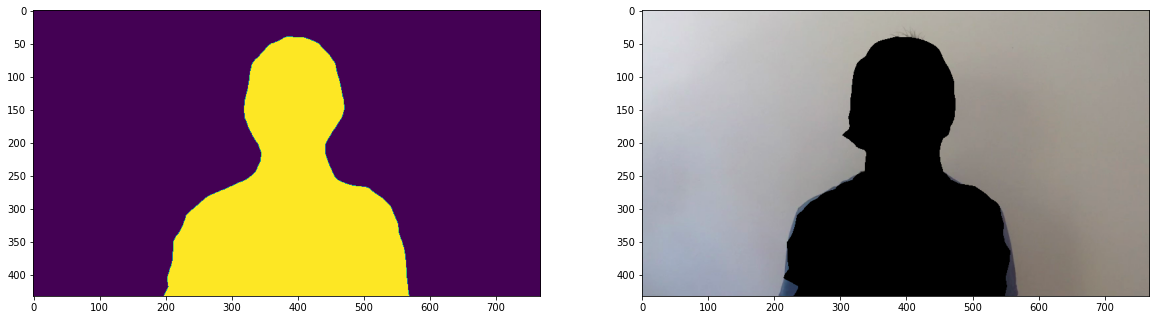

In [103]:
seg_mask = cv2.resize(segmentation_map, (c,r))
converted_mask = np.zeros((r,c))
converted_mask = np.argmax(seg_mask, axis=2)

image_copy = original_image.copy()
image_copy[bg_mask > 18.0] = 0.0
f, ax = plt.subplots(1,2)
f.set_size_inches((20, 25))
ax[0].imshow(converted_mask)
ax[1].imshow(image_copy)
plt.show()

In [105]:
np.max(converted_mask)

15